In [ ]:
%load_ext autoreload
%autoreload 2

In [76]:
 import ast
from build import item
from build import build
from build.config import dmg
import utils.skillpoints as sp
from utils import dmgcalc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np

In [81]:
def get_data(weapon, file):
    with open(file, 'r') as f:
        lines = f.readlines()
    score = []
    real = []
    builds = []
    reqsps = []
    bonsps = []
    freesp = []
    
    for i, text in enumerate(lines):
        data = ast.literal_eval(text)
        real.append(data[1])
        score.append(data[2])
    
        items = [item.get_item(n) for n in data[0]]
        b = build.Build(weapon, *items)
        reqsp, bonsp = b.calc_sp()
        reqsps.append(reqsp)
        bonsps.append(bonsp)
        freesp.append(204-sum(reqsp))
    
        builditem = sp.add_sp(b.build(), *b.calc_sp())
        for t,m in zip(dmgcalc.damageTypes, dmg.mastery):
            builditem.identifications[t] += 15*m
        builds.append(builditem)
    return (score, real, builds, reqsps, bonsps, freesp)
    
def plot2D(x, y, r=None, bins=None, xlabel='x', ylabel='y'):
    if r is None:
        r = [[min(x),max(x)],[min(y),max(y)]]
    if bins is None:
        bins=(100,100)
    plt.hist2d(x, y, bins=bins, cmap='jet', norm=colors.LogNorm(), range = r)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def normalise(data):
    m = min(data)
    d = 1/(max(data)-min(data))
    return [(x-m)*d for x in data]

def plot3D(x,y,z,bins=(25,25,100),xlabel='x',ylabel='y',zlabel='z'):
    hist, edges = np.histogramdd((x,y,z), bins=bins)
    mids = []
    for edge in edges:
        mid = []
        for i in range(len(edge)-1):
            mid.append((edge[i+1] + edge[i])/2)
        mids.append(mid)
    
    x = []
    y = []
    z = []
    density = []
    for i,a in enumerate(mids[0]):
        for j,b in enumerate(mids[1]):
            for k,c in enumerate(mids[2]):
                if hist[i,j,k] != 0:
                    x.append(a)
                    y.append(b)
                    z.append(c)
                    density.append(hist[i,j,k])
                    
    mlab.figure('DensityPlot')
    mlab.points3d(x, y, z, density, scale_mode='none', scale_factor=0.02)
    mlab.axes(xlabel='score',ylabel='sp',zlabel='real')
    mlab.show()

elements = ['neutral', 'earth', 'thunder', 'water', 'fire', 'air']
Elements = ['Neutral', 'Earth', 'Thunder', 'Water', 'Fire', 'Air']
damageTypes = ["damage", "earthDamage", "thunderDamage",  "waterDamage", "fireDamage", "airDamage"]
def data_to_pandas(weapon,data):
    mastery = [False, False, True, False, False]
    spellmod = [0.3, 0, 0.15, 0.1, 0, 0]
    base_dmg_max, base_dmg_min = dmgcalc.base_dmg(weapon, spellmod, mastery)
    relevant_ids = ["rawStrength", "rawDexterity", "rawIntelligence", "rawDefense", "rawAgility", 'rawSpellDamage',
                    'spellDamage', "elementalDamage", "rawElementalDamage", "rawElementalSpellDamage", "elementalSpellDamage"]
    for i in range(6):
        if base_dmg_max[i] > 0:
            relevant_ids += [damageTypes[i], elements[i]+'SpellDamage', 'raw'+Elements[i]+'Damage', 'raw'+Elements[i]+'SpellDamage']
    df = pd.DataFrame({'score':data[0],'real':data[1],'reqsp':data[3],'bonsp':data[4],'freesp':data[5]})
    for i in relevant_ids:
        df[i] = [it.identifications[i].max for it in data[2]]
    
    return df

In [84]:
nirvana = item.get_weapon('Nirvana').set_powders(["w", "w", "w"])
nirvdata = get_data(nirvana, 'output/Nirvana401451.txt')
nirvdf = data_to_pandas(nirvana,nirvdata)

In [85]:
cataclysm = item.get_weapon("Cataclysm").set_powders(["t", "t", "t"])
catadata = get_data(cataclysm, 'output/Cataclysm493678.txt')
catadf = data_to_pandas(cataclysm,catadata)

95.0 237043
140.0 453746
235.0 234086


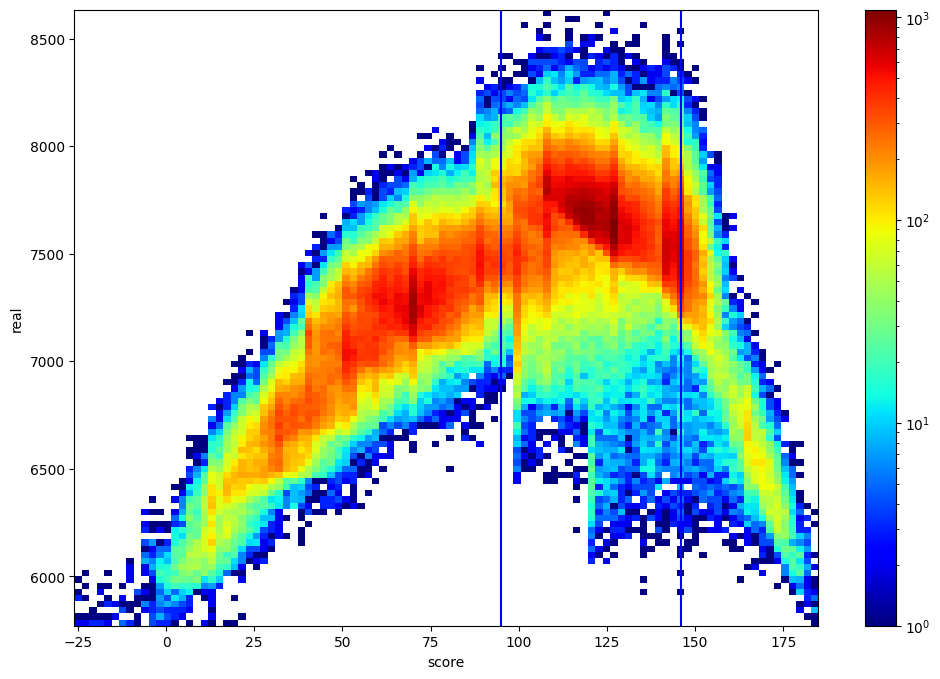

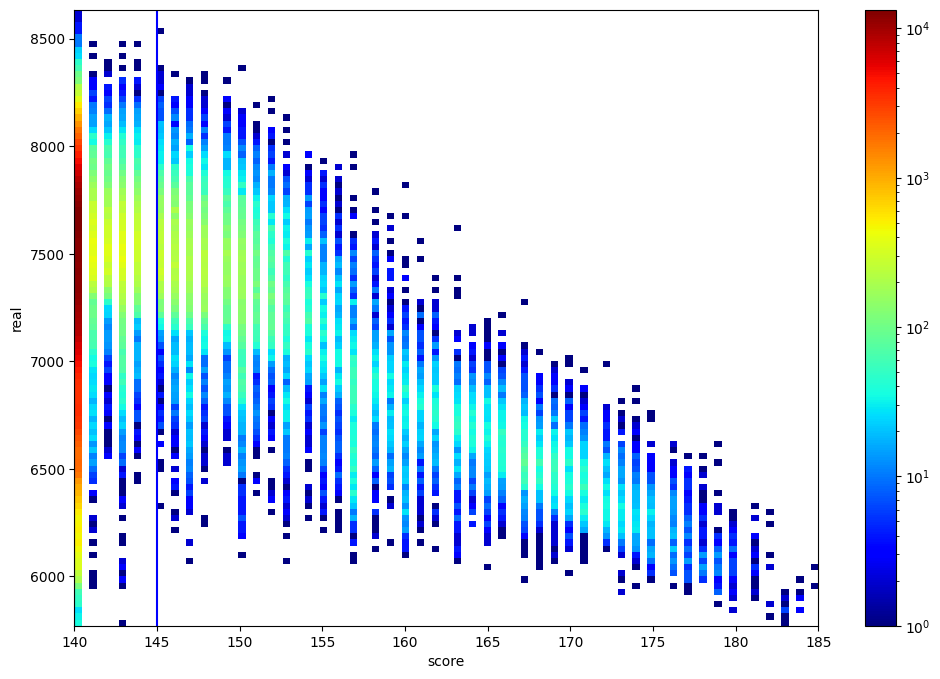

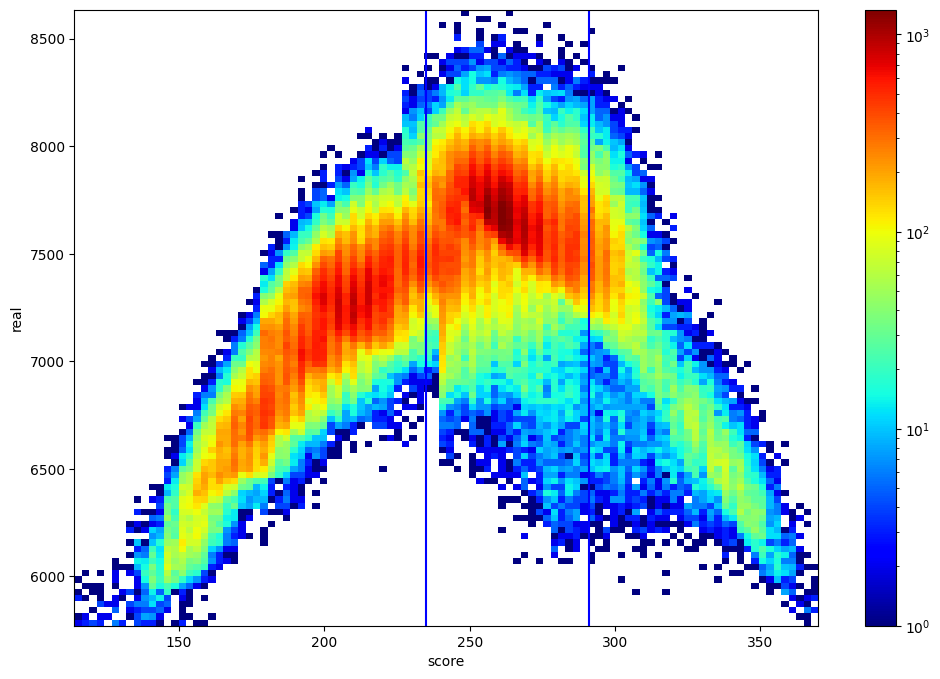

In [58]:
#scores, reals, builds = nirvdata[0:3]
scores, reals, builds = catadata[0:3]

spsum = [i.identifications['rawStrength'].max + i.identifications['rawDexterity'].max for i in builds]

factor = 2.42
x = [(1*i.identifications['rawStrength'].max + 0*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')


x = [(0*i.identifications['rawStrength'].max + 1*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')

x = [(1*i.identifications['rawStrength'].max + 1*i.identifications['rawDexterity'].max) + 0*s for i,s in zip(builds, scores)]
#x = scores
#x = [1*(dmgcalc.spToPct(i.identifications['rawStrength'].max) + dmgcalc.spToPct(i.identifications['rawDexterity'].max)) + s for i,s in zip(builds, snorm)]
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[reals[-100],reals[0]]]

plt.figure(figsize=(12,8))
plot2D(x,reals,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')

493678 468249
7496.004318587855 41468


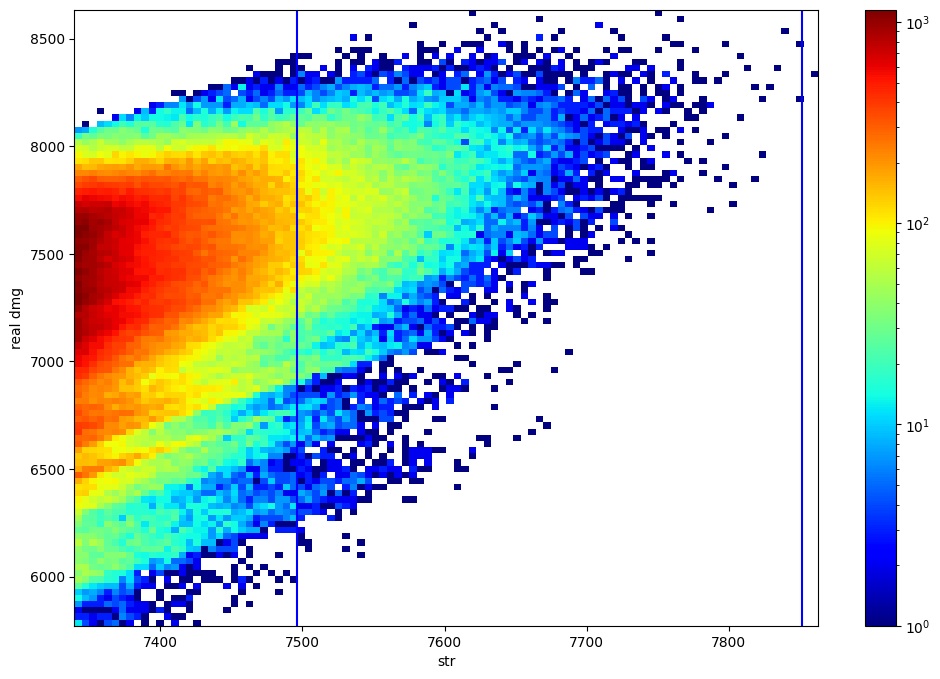

In [113]:
cutdf = catadf.query('rawStrength<150 & rawDexterity<150')
print(catadf.shape[0], cutdf.shape[0])

f = 0
x = cutdf.eval(f'{f}*(rawStrength + rawDexterity) + score')
y = cutdf['real']
threshold = min(x[0:100])
threshold2 = max(x[0:100])
print(threshold, len([i for i in x if threshold <= i <= threshold2]))

r = [[min(x[-200:-100]),max(x)],[y.iloc[-100],y.iloc[0]]]

plt.figure(figsize=(12,8))
plot2D(x,y,r=r,xlabel='str',ylabel='real dmg')
plt.axvline(threshold,color='b')
plt.axvline(threshold2,color='b')
plt.show()

In [ ]:
cutdf = nirvdf.query('rawStrength<150 & rawDexterity<150')
print(catadf.shape[0], cutdf.shape[0])

y = cutdf['real']
for col in cutdf.columns:
    if col in ['reqsp','bonsp']:
        continue
    amounts = []
    for f in np.linspace(-5,10,61):
        x = cutdf.eval(f'{f}*{col} + score')
        threshold = min(x[0:100])
        amounts.append(len([i for i in x if threshold <= i]))
    f = np.linspace(-5,10,61)[np.argmin(amounts)]
    x = cutdf.eval(f'{f}*{col} + score')
    threshold = min(x[0:100])
    threshold2 = max(x[0:100])
    print(col, f, threshold, len([i for i in x if threshold <= i <= threshold2]))
    
    r = [[min(x[-200:-100]),max(x)],[y.iloc[-100],y.iloc[0]]]
    
    plt.figure(figsize=(12,8))
    plot2D(x,y,r=r,xlabel=f'{f}*{col} + score',ylabel='real dmg')
    plt.axvline(threshold,color='b')
    plt.axvline(threshold2,color='b')
plt.show()

In [137]:
df = catadf
tot = df.shape[0]
for col in df.columns:
    if col in ['reqsp','bonsp']:
        continue
    print(col, min(df[col]), max(df[col]))
    threshold = min(df[col].iloc[0:100])
    print(threshold, round(df.query(f'{col}>={threshold}').shape[0]/tot,3))
    threshold2 = max(df[col].iloc[0:100])
    print(threshold2, round(df.query(f'{col}<={threshold2}').shape[0]/tot,3))

score 7337.178341050011 7862.973945804806
7496.004318587855 0.094
7851.565368853806 1.0
real 5529.3317914499 8634.60646126598
8399.366445745974 0.0
8634.60646126598 1.0
reqsp [0, 43, 0, 0, 0] [102, 95, 0, 0, 0]
bonsp [-46, 39, -31, -46, -24] [76, 87, -50, 0, 0]
freesp 0 161
18 0.896
128 0.961
rawStrength -36 185
95 0.546
146 0.934
rawDexterity 140 185
140 1.0
145 0.919
rawIntelligence -71 129
-61 0.996
-11 0.175
rawDefense 0 0
0 1.0
0 1.0
rawAgility -57 11
-29 0.939
-7 0.967
rawSpellDamage -30 1236
171 0.948
965 0.999
spellDamage -3 287
176 0.549
254 0.998
elementalDamage 0 26
0 1.0
0 1.0
rawElementalDamage 0 195
0 1.0
0 0.997
rawElementalSpellDamage 0 0
0 1.0
0 1.0
elementalSpellDamage 0 38
0 1.0
0 1.0
damage 0 0
0 1.0
0 1.0
neutralSpellDamage 0 0
0 1.0
0 1.0
rawNeutralDamage 0 0
0 1.0
0 1.0
rawNeutralSpellDamage 0 231
0 1.0
0 1.0
thunderDamage 73 357
127 0.925
259 0.987
thunderSpellDamage 0 23
0 1.0
0 1.0
rawThunderDamage 0 0
0 1.0
0 1.0
rawThunderSpellDamage 0 0
0 1.0
0 1.0
waterDam